# Paid Parking Availability in the city of Seattle

For this capstone project we used paid parking data for the city of Seattle to try and get a better understanding of how well the residents are served by the current paid parking options at different times and in different areas. Free parking occupancy data was unfortunately not available. 

Here are some of the questions that we were asking:

* How does time-of-day, day-of-the-week and location affect parking availability?
* Can we notice any patterns?
* How well does the city serve the supply and demand of paid parking? Is there enough parking available across the city?

## Acknowledgements

Early on in the data we noticed that there are sometimes more parking spaces occupied than there should be available. We assume that in some cases people were able to park more vehicles in a given area than the city designated. To make our work a bit easier we counted a parking location as full when it reached the city specified limit, and disregarded the ingenuity of individuals who squeezed in more vehicles than an area has been designated for.

We used a vast dataset with nearly 300MM entries. To make our lives a bit easier we decided to only use a months worth of data for this exercise, from 21.03.2018 to 20.04.2018. There was also a bit of data wrangling necessary. To know more about the process and about how the data is structured, please refer to this [document](https://docs.google.com/document/d/16j_GM1oubSwtyjYKlvqoia0RA8VjyBBuwKSsIdQNtoU/edit?usp=sharing). 

You may find the original dataset [here](https://data.seattle.gov/Transportation/2018-Paid-Parking-Occupancy-Year-to-date-/6yaw-2m8q) and the zip code boundries data [here](https://gis-kingcounty.opendata.arcgis.com/datasets/zipcodes-for-king-county-and-surrounding-area-zipcode-area)

## Reading in the Data

In [267]:
# import libraries
import csv
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap, HeatMapWithTime

%matplotlib inline

In [290]:
# import zip code shape data
seattle_zip_data = gpd.read_file('Seattle_zipcode_data_new.shp')

In [80]:
# import data
data_2018 = pd.read_csv('Data_2018_added_ZIP.csv')

In [81]:
# import zip data grouped by zipcodes
data_groupby_zip = pd.read_csv('Data_2018_groupedby_zip_and_sum.csv')

In [14]:
# import parking area data
data_groupby_parking_area = pd.read_csv('Data_2018_groupedby_ParkingArea_and_sum.csv')

In [321]:
# extract data for selected zip code
data_zip_98121 = data_groupby_zip[data_groupby_zip['ZIP'] == 98121]

In [20]:
# extract data for selected parking area
data_BallardLocks = data_groupby_parking_area[data_groupby_parking_area['PaidParkingArea'] == 'Ballard Locks']

In [84]:
# extract data for selected date
data_2018_day_3003 =  data_2018[data_2018['Date'] == '03/30/2018']

In [278]:
# Seattle zip codes with paid parking
seattle_zc = [98101, 98102, 98103, 98104, 98105, 98107, 98109, 98115, 98118, 98119, 98121, 98122, 98134, 98154, 98164]

In [317]:
# sort days
data_groupby_zip['Weekday']= pd.Categorical(data_groupby_zip['Weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], ordered=True)

## Exploration Based on Time-of-day and Day-of-the-week 

First we wanted to check how paid parking availability is changing throughout the day across all locations for the designated one-month period. The graph below shows average parking availability across days of the week (excluding Sunday when parking is free) between 8:00 and 22:00 (for the hours outside of that parking is also free). From the graph we can see that for the most part the availability is similar across days of the week. The only outlier is Saturday, which is expected since most people don’t work on those days and are on a different schedule.

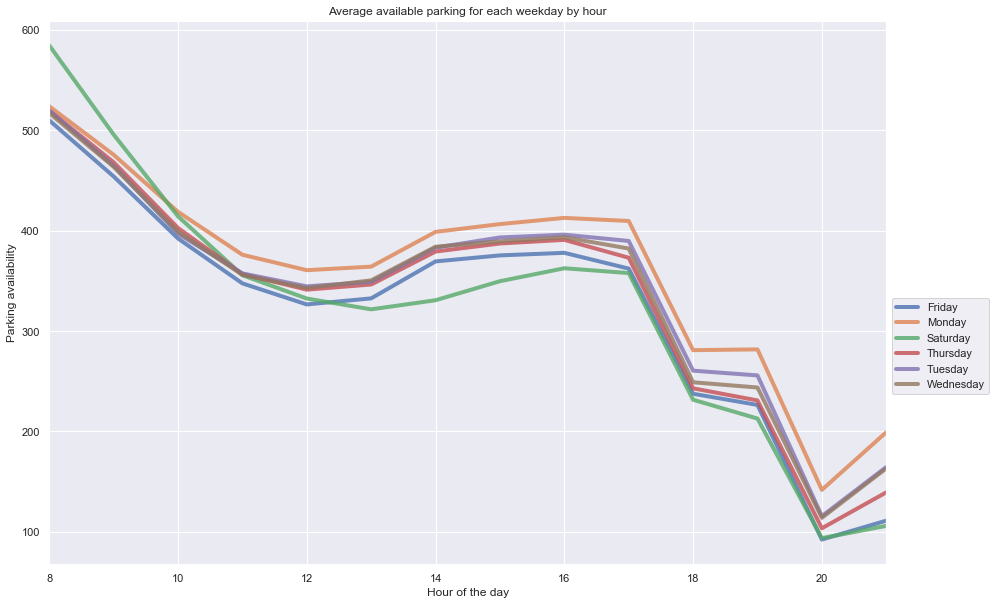

In [243]:
data_groupby_zip.groupby(['HourIn24HourClock', 'Weekday'])['AdjustedParkingAvailability'].mean().unstack().plot.line(linewidth=4, figsize=(15, 10), stacked=False, title='Average available parking for each weekday by hour', alpha=0.8)
plt.xlabel('Hour of the day')
plt.ylabel('Parking availability')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()

We made a similar graph for paid parking occupancy. As anticipated the graph looks similar to the one above, only inverted. As occupancy rises, availability drops. 

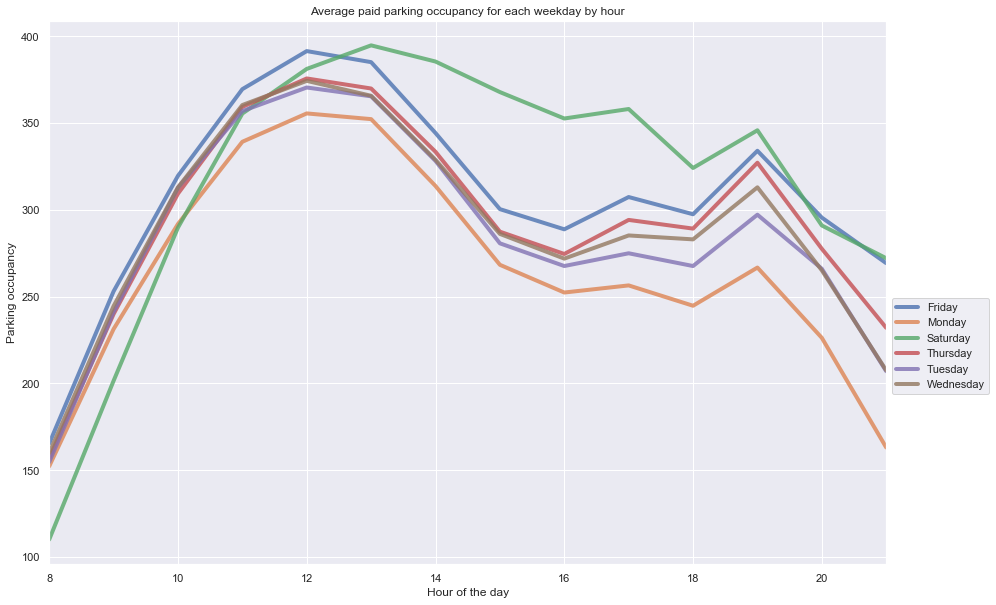

In [255]:
data_groupby_zip.groupby(['HourIn24HourClock', 'Weekday'])['PaidOccupancy'].mean().unstack().plot.line(linewidth=4, figsize=(15, 10), stacked=False, title='Average paid parking occupancy for each weekday by hour', alpha=0.8)
plt.xlabel('Hour of the day')
plt.ylabel('Parking occupancy')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()

To make sure that occupancy and availability are as tightly connected as it appears in the graphs above, we created a stacked bar graph. The expectation would be that the top of the bar graph should be flat. This is true for the most part, except for two sudden drops one at 18:00 and another one at 20:00. The reason for those is that in certain zip codes parking becomes free after 18:00 or 20:00, which changes the average availability of paid parking across the zip codes.

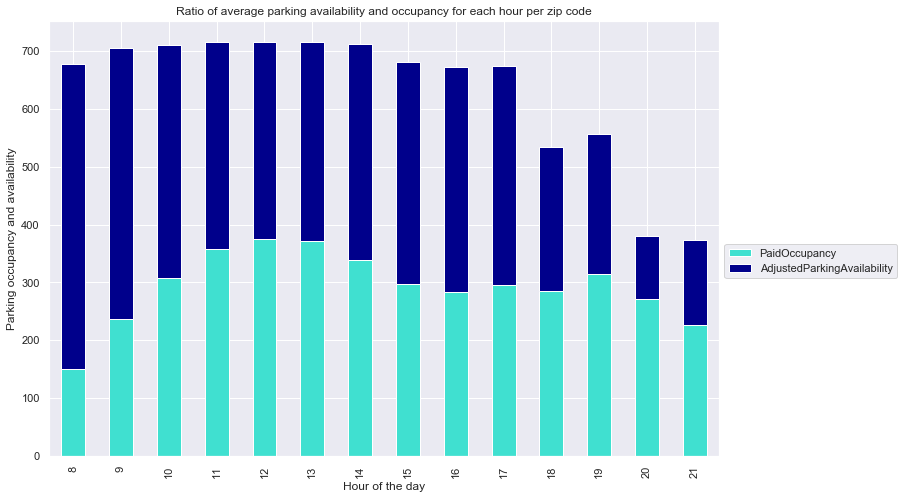

In [252]:
# plot stacked bargraph of average occupied and available paid parking spaces
data_groupby_zip.groupby('HourIn24HourClock')['PaidOccupancy','AdjustedParkingAvailability'].mean().plot(kind='bar', stacked=True, color=['turquoise', 'darkblue'], figsize=(12, 8))
plt.xlabel('Hour of the day')
plt.ylabel('Parking occupancy and availability')
plt.title('Ratio of average parking availability and occupancy for each hour per zip code')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()

To make sure there is indeed a strong connection between occupancy and availability, we plotted all the data points on a scatter plot. There is strong visible inverse correlation that also show clear distinctions between different zip codes.

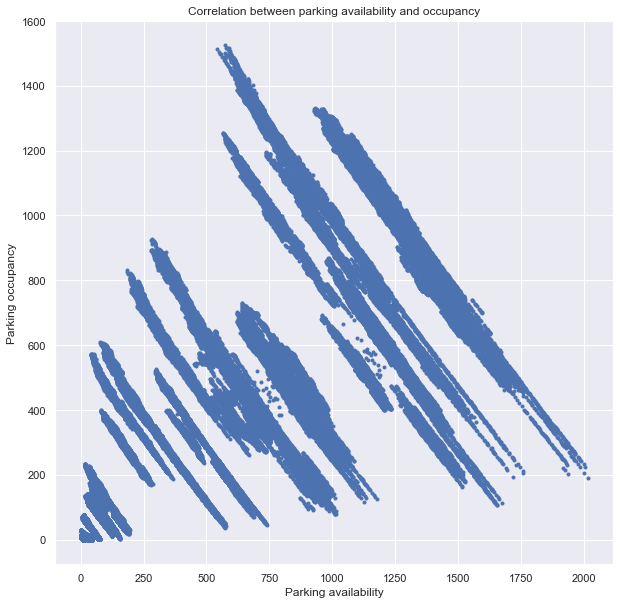

In [345]:
plt.figure(figsize=(10,10))
_ = plt.plot(data_groupby_zip['AdjustedParkingAvailability'], data_groupby_zip['PaidOccupancy'], marker='.', linestyle='none')
_ = plt.xlabel('Parking availability')
_ = plt.ylabel('Parking occupancy')
_ = plt.title('Correlation between parking availability and occupancy')
plt.show()

## Exploration Based on Location 

When we look at average parking availability based on location, in this case zip codes, we can notice a similar pattern emerge to the graphs above. But in this case we are able to identify how availability varies throughout the day for each zip code and identify the areas where paid parking ends sooner. Only three zip code locations - 98101, 98102, 98122 - have paid parking through most of the day, from 8:00 to 22:00. With the lowest availability of paid parking during the workday being from 12:00 to 14:00.  

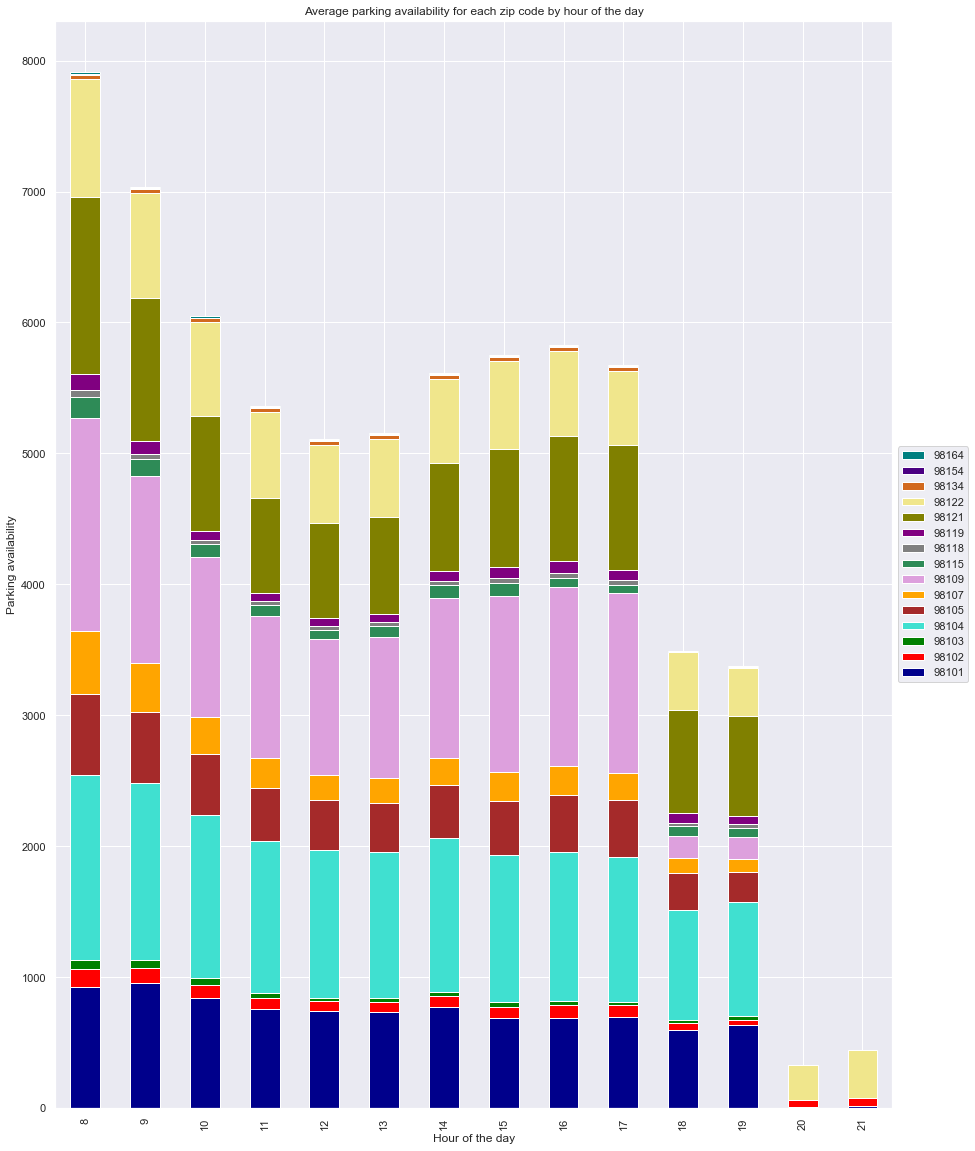

In [232]:
# plot a graph for parking availability based on hour of a day and zip code
multi_colors = ['darkblue', 'red', 'green', 'turquoise', 'brown', 'orange', 'plum', 'seagreen', 'grey', 'purple', 'olive', 'khaki', 'chocolate', 'indigo', 'teal']
ax = data_groupby_zip.groupby(['HourIn24HourClock', 'ZIP'])['AdjustedParkingAvailability'].mean().unstack().plot(kind='bar', stacked=True, color=multi_colors, figsize = (15,20))
plt.xlabel('Hour of the day')
plt.ylabel('Parking availability')
plt.title('Average paid parking availability for each zip code by hour of the day')
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

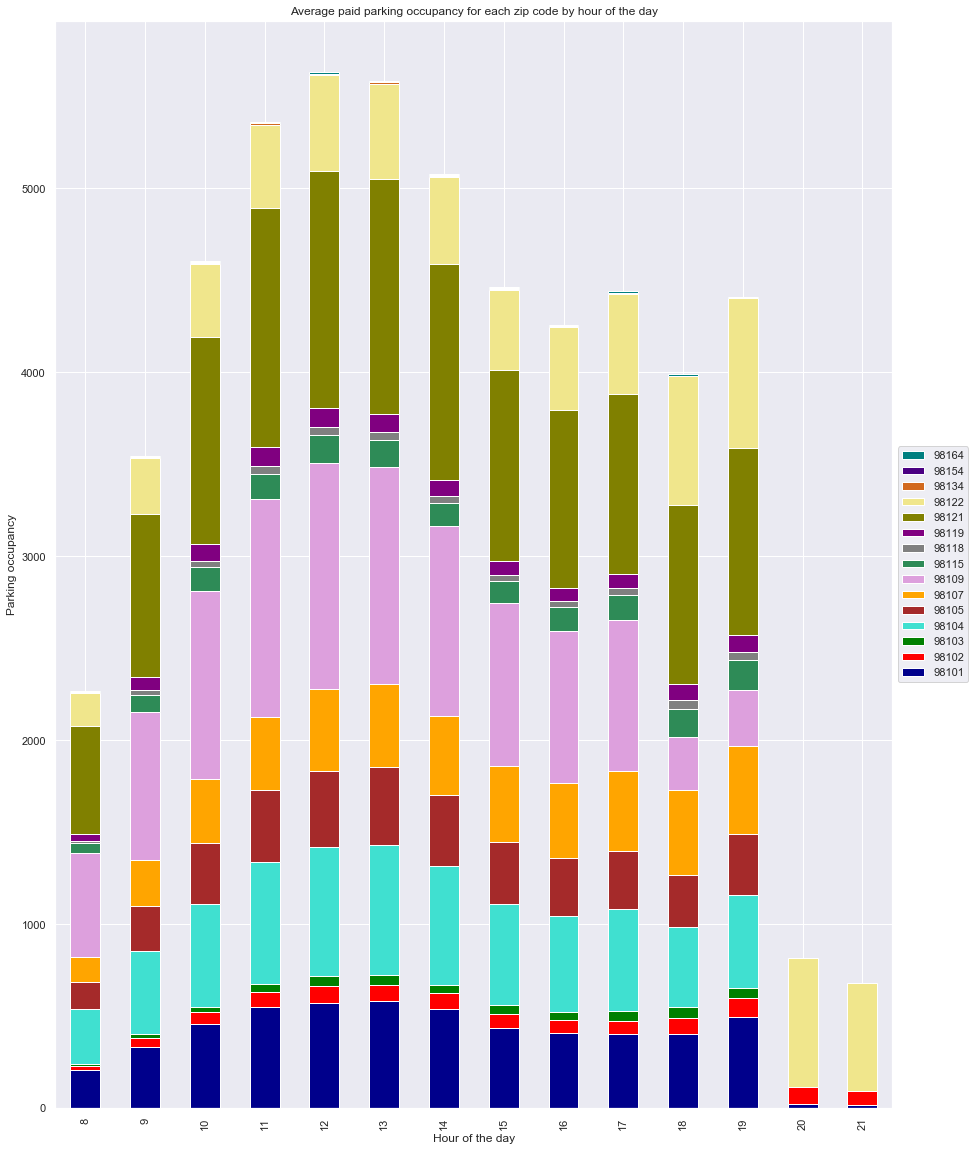

In [235]:
# plot a graph for paid parking based on hour of a day and zip code
ax = data_groupby_zip.groupby(['HourIn24HourClock', 'ZIP'])['PaidOccupancy'].mean().unstack().plot(kind='bar', stacked=True, color=multi_colors, figsize = (15,20))
plt.xlabel('Hour of the day')
plt.ylabel('Parking occupancy')
plt.title('Average paid parking occupancy for each zip code by hour of the day')
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

All three of the aforementioned zip code locations are in and around Capitol Hill, which is an area that is popular throughout the day. How parking occupancy changes through the day can be seen on the heatmap time series below. The other things worth noting is that zip codes 98154 and 98164 are the size of a block each. Which also explains why data from them are barely visible on the bar graphs above. The data we used for this map is from 30.03.2018 which is the day with the highest occupancy during the week within our timeframe, as it would be the most interesting to look at.

In [329]:
# find minimum of longitudes
lon_min_day_3003 = data_2018_day_3003['Longitude'].min()
# find maximum of longitudes
lon_max_day_3003 = data_2018_day_3003['Longitude'].max()
# find average of longitudes
lon_avg_day_3003 = (lon_min_day_3003 + lon_max_day_3003)/2
# find minimum of latitudes
lat_min_day_3003 = data_2018_day_3003['Latitude'].min()
# find maximum of latitudes
lat_max_day_3003 = data_2018_day_3003['Latitude'].max()
# find average of latitudes
lat_avg_day_3003 = (lat_min_day_3003 + lat_max_day_3003)/2

In [330]:
# create a copy of the data
import copy
data_2018_day_3003_copy = data_2018_day_3003.copy()

In [331]:
# create a list with hours, when parking is charged
time_index = list(data_2018_day_3003_copy.HourIn24HourClock.sort_values().unique())

In [332]:
# create a list with all parking locations and paid occupancy
df_hour_list_occupancy = []
for hour_occupancy in time_index:
    df_hour_list_occupancy.append(data_2018_day_3003_copy.loc[data_2018_day_3003_copy.HourIn24HourClock == hour_occupancy, ['Latitude', 'Longitude', 'PaidOccupancy']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist())

In [333]:
# set the map location
heatmap_time_occupancy = folium.Map([lat_avg_day_3003, lon_avg_day_3003], zoom_start=14)

In [334]:
# adding zip codes boundaries
folium.GeoJson(data_zipcodes_seattle['geometry']).add_to(heatmap_time_occupancy)

In [335]:
# adding markers to the map
for i in range(0, len(data_zipcodes_seattle)):
    folium.Marker([seattle_zip_data.iloc[i]['latitude'], seattle_zip_data.iloc[i]['longitude']], popup=seattle_zip_data.iloc[i]['ZIPCODE']).add_to(heatmap_time_occupancy)

In [336]:
HeatMapWithTime(df_hour_list_occupancy, index=time_index, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(heatmap_time_occupancy)

In [337]:
heatmap_time_occupancy

If we look at average parking availability on a per day-of-the-week basis, we notice that Mondays have the highest availability of paid parking spots. While on Saturdays the destinations with paid parking in those areas are on average more popular. Data for Sundays is not available, because parking on Sundays is free.

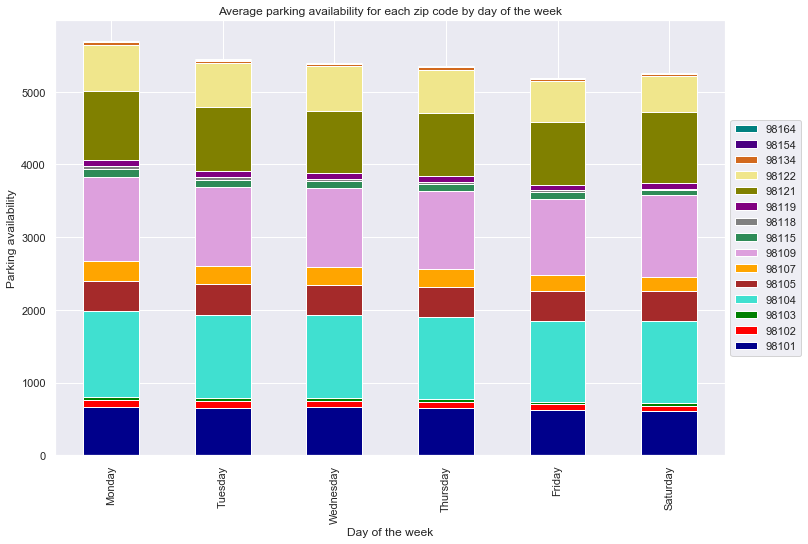

In [318]:
# plot a graph for parking availability based on day in a week and zip code
ax = data_groupby_zip.groupby(['Weekday', 'ZIP'])['AdjustedParkingAvailability'].mean().unstack().plot(kind='bar', stacked=True, color=multi_colors, figsize = (12,8))
plt.xlabel('Day of the week')
plt.ylabel('Parking availability')
plt.title('Average parking availability for each zip code by day of the week')
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

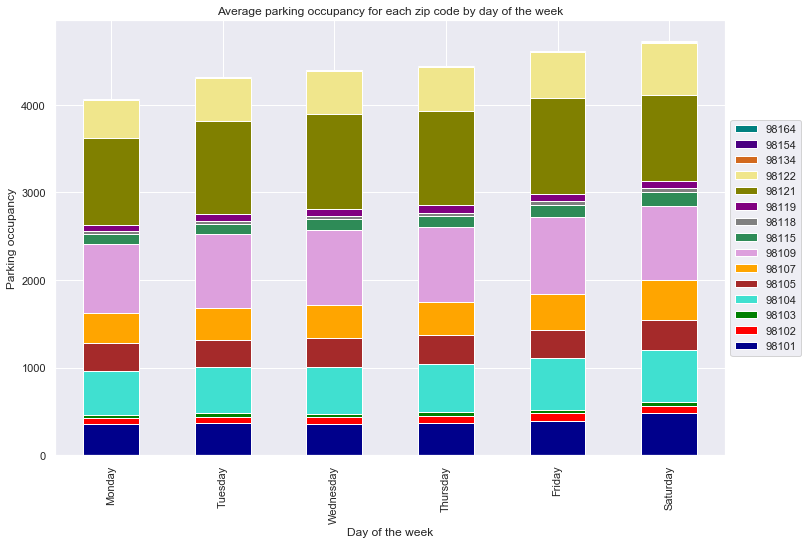

In [319]:
# plot a graph for parking availability based on day in a week and zip code
ax = data_groupby_zip.groupby(['Weekday', 'ZIP'])['PaidOccupancy'].mean().unstack().plot(kind='bar', stacked=True, color=multi_colors, figsize = (12,8))
plt.xlabel('Day of the week')
plt.ylabel('Parking occupancy')
plt.title('Average parking occupancy for each zip code by day of the week')
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## Patterns and Exceptions

So far we mainly looked at the data in aggregate across days of the week. If we plot out all the dates in our designated timeframe, we can notice a pattern emerge throughout most weeks, where paid parking availability is highest at the beginning of the week and declines towards the end of it. 

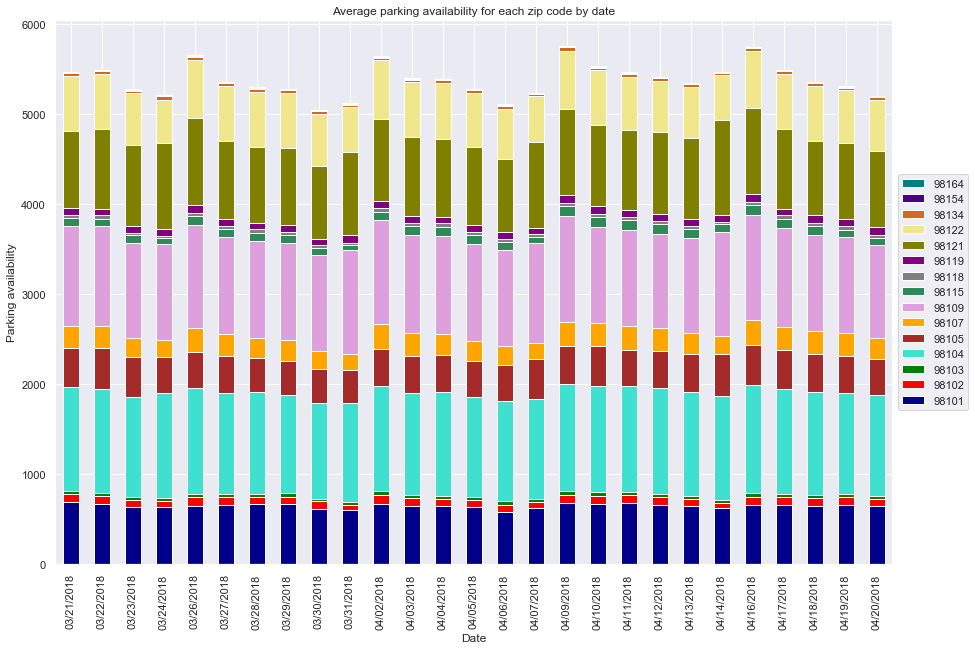

In [229]:
# plot a graph for average parking availability based on a date and zip code
ax = data_groupby_zip.groupby(['Date', 'ZIP'])['AdjustedParkingAvailability'].mean().unstack().plot(kind='bar', stacked=True, figsize = (15,10), color=multi_colors)
plt.xlabel('Date')
plt.ylabel('Parking availability')
plt.title('Average parking availability for each zip code by date')
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

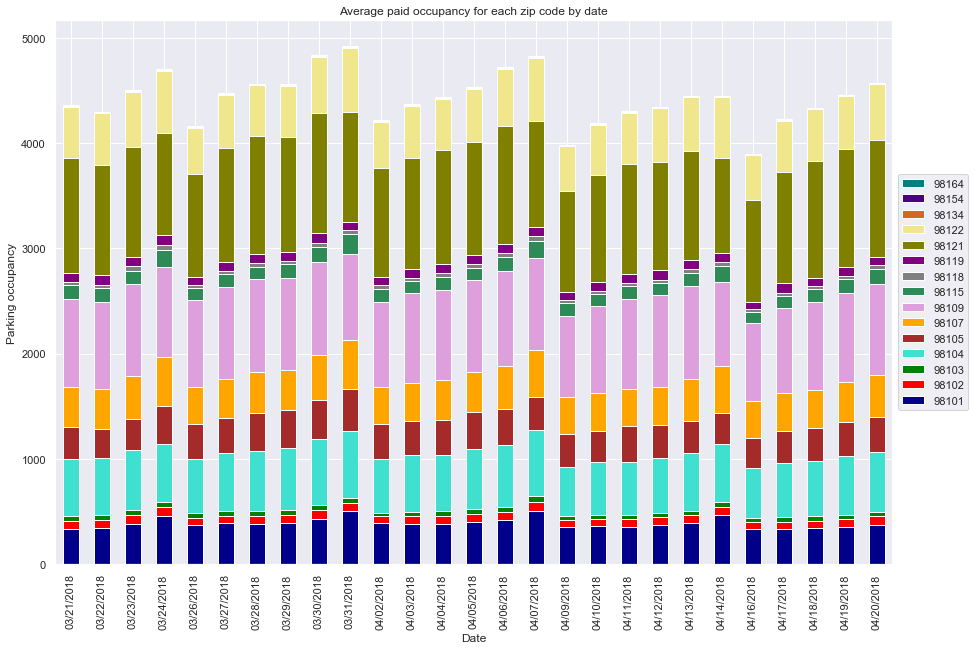

In [233]:
# plot a graph for average parking availability based on a date and zip code
#multi_colors = ['darkblue', 'red', 'green', 'turquoise', 'grey', 'orange', 'pink', 'seagreen', 'yellow', 'purple', 'aqua', 'brown', 'blue', 'indigo', 'teal']
ax = data_groupby_zip.groupby(['Date', 'ZIP'])['PaidOccupancy'].mean().unstack().plot(kind='bar', stacked=True, figsize = (15,10), color=multi_colors)
plt.xlabel('Date')
plt.ylabel('Parking occupancy')
plt.title('Average paid occupancy for each zip code by date')
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

There are not only patterns on a weekly basis, but also in the hours of the day. At a glance there is very little variation between days of the week. The only exception being Saturdays.

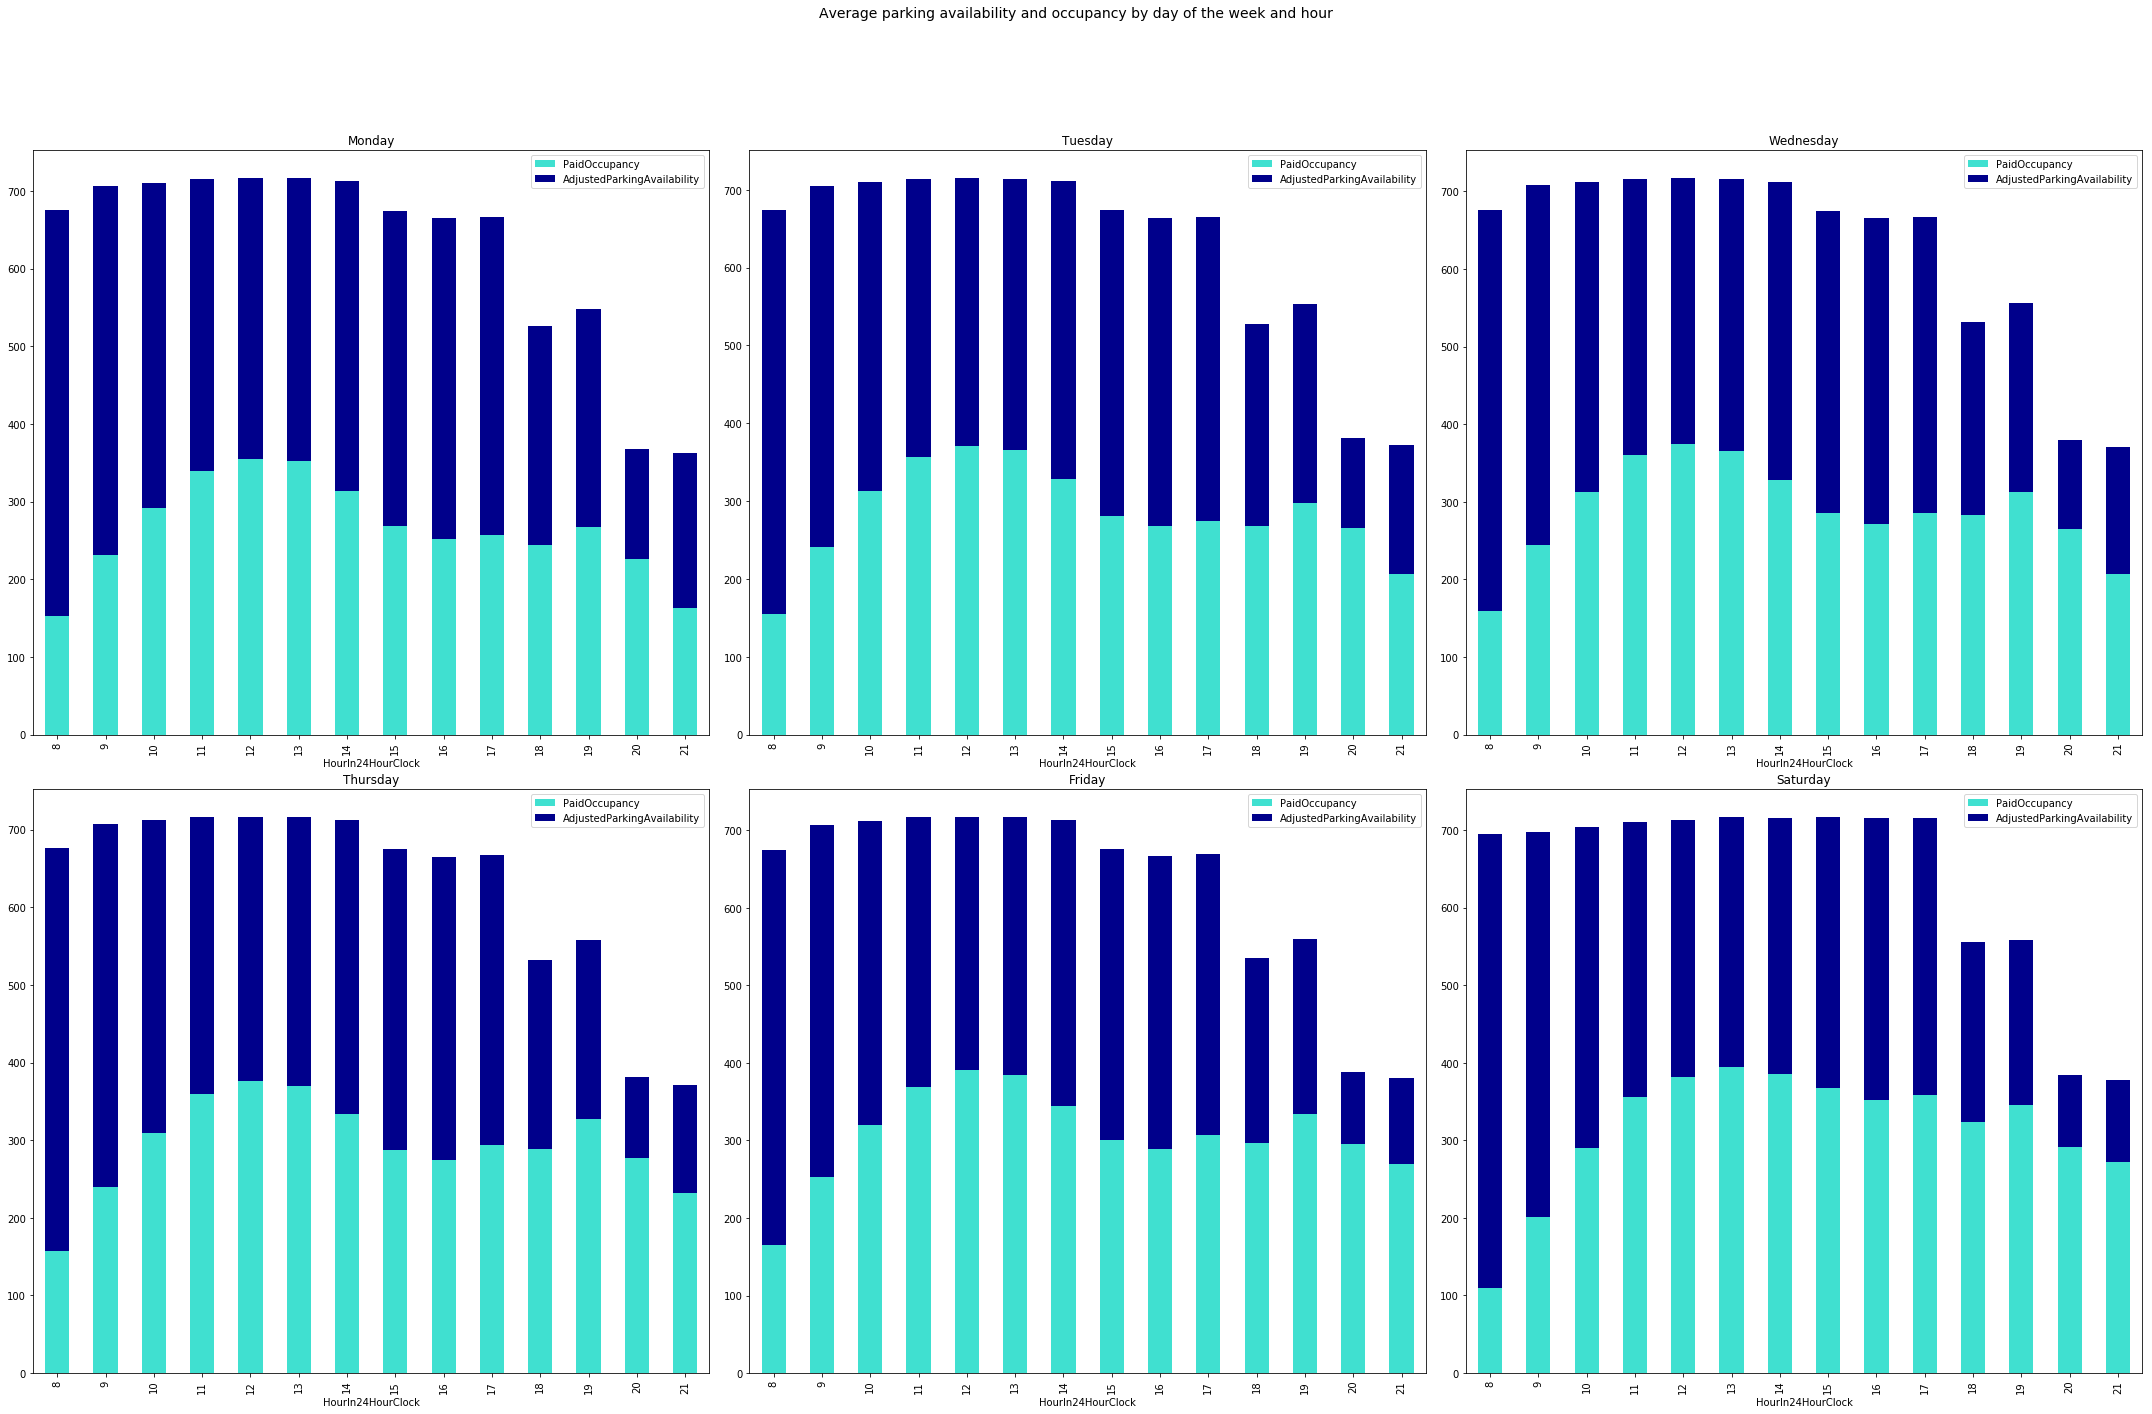

In [30]:
# plot subplots by day of the week for average parking - both available and occupied - for each hour
two_colors= ['turquoise', 'darkblue']
fig, axes = plt.subplots(2, 3, figsize=(30, 20))

mon_day = data[data['Weekday']=='Monday'].groupby('HourIn24HourClock')['PaidOccupancy', 'AdjustedParkingAvailability'].mean().plot(kind='bar', stacked=True, color=two_colors, ax=axes[0, 0])
mon_day.set_title('Monday')
tue_day = data[data['Weekday']=='Tuesday'].groupby('HourIn24HourClock')['PaidOccupancy', 'AdjustedParkingAvailability'].mean().plot(kind='bar', stacked=True, color=two_colors, ax=axes[0, 1])
tue_day.set_title('Tuesday')
wed_day = data[data['Weekday']=='Wednesday'].groupby('HourIn24HourClock')['PaidOccupancy', 'AdjustedParkingAvailability'].mean().plot(kind='bar', stacked=True, color=two_colors, ax=axes[0, 2])
wed_day.set_title('Wednesday')
thu_day = data[data['Weekday']=='Thursday'].groupby('HourIn24HourClock')['PaidOccupancy', 'AdjustedParkingAvailability'].mean().plot(kind='bar', stacked=True, color=two_colors, ax=axes[1, 0])
thu_day.set_title('Thursday')
fri_day = data[data['Weekday']=='Friday'].groupby('HourIn24HourClock')['PaidOccupancy', 'AdjustedParkingAvailability'].mean().plot(kind='bar', stacked=True, color=two_colors, ax=axes[1, 1])
fri_day.set_title('Friday')
sat_day = data[data['Weekday']=='Saturday'].groupby('HourIn24HourClock')['PaidOccupancy', 'AdjustedParkingAvailability'].mean().plot(kind='bar', stacked=True, color=two_colors, ax=axes[1, 2])
sat_day.set_title('Saturday')

fig.suptitle('Average paid parking availability and occupancy by day of the week and hour', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

We also wanted to take a look at how much paid parking occupancy and availability vary across different days of the week. The spreads as well as the centers for days of the week across all zip codes appear very similar.

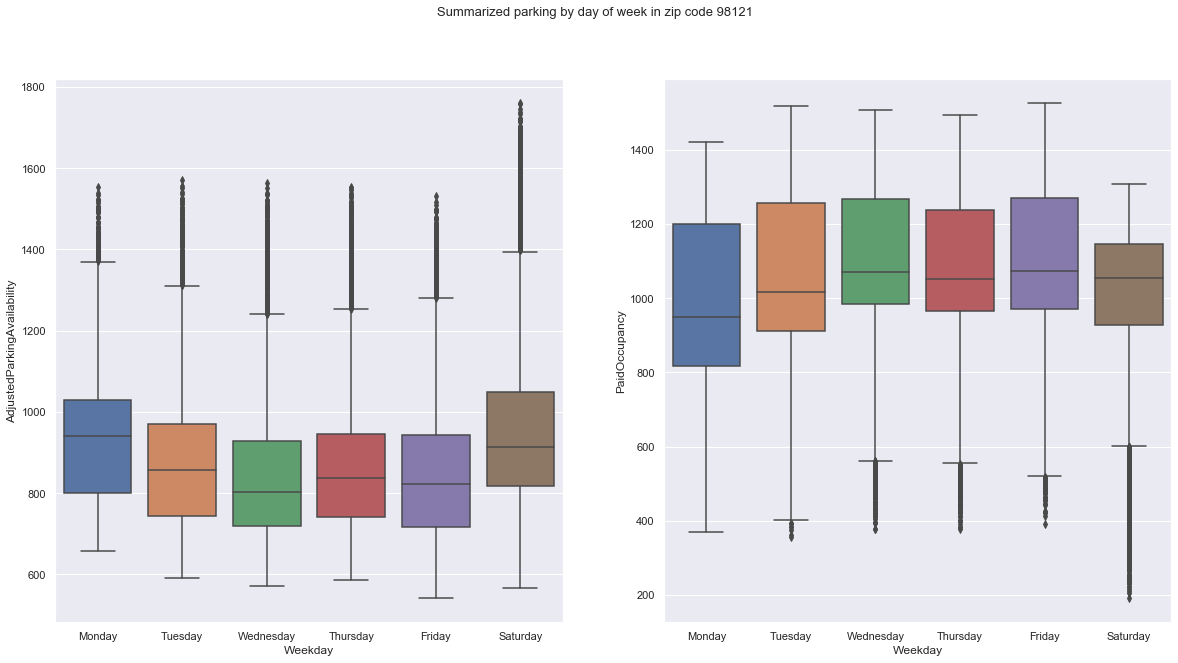

In [349]:
fig, ax = plt.subplots(ncols = 2, figsize=(20, 10))
_ = sns.boxplot(x='Weekday', y='AdjustedParkingAvailability', data=data_zip_98121, ax=ax[0])
_ = sns.boxplot(x='Weekday', y='PaidOccupancy', data=data_zip_98121, ax=ax[1])
_ = plt.suptitle('Summarized parking by day of week in zip code 98121', fontsize=13)
plt.show()

Looking at all the zipcodes didn't show much variability so we took a closer look at one of the busier zip codes - 98121. The top two boxplots are for days during the week while the bottom two represent Saturdays. Here again we notice that both parking occupancy and availability don't go far outside the regular daily patterns. Still, the spreads are a bit larger towards the end of the day when compared to the middle of the day. The assumption here is that in the evenings people have more flexibility to attend activities they are interested in rather than be beholden to a more rigid work schedule.

In [214]:
# create two dataframes, one for week and one for saturdays
data_zip_98121_week = data_zip_98121.loc[data_zip_98121['Weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
data_zip_98121_saturday = data_zip_98121[data_zip_98121['Weekday']=='Saturday']

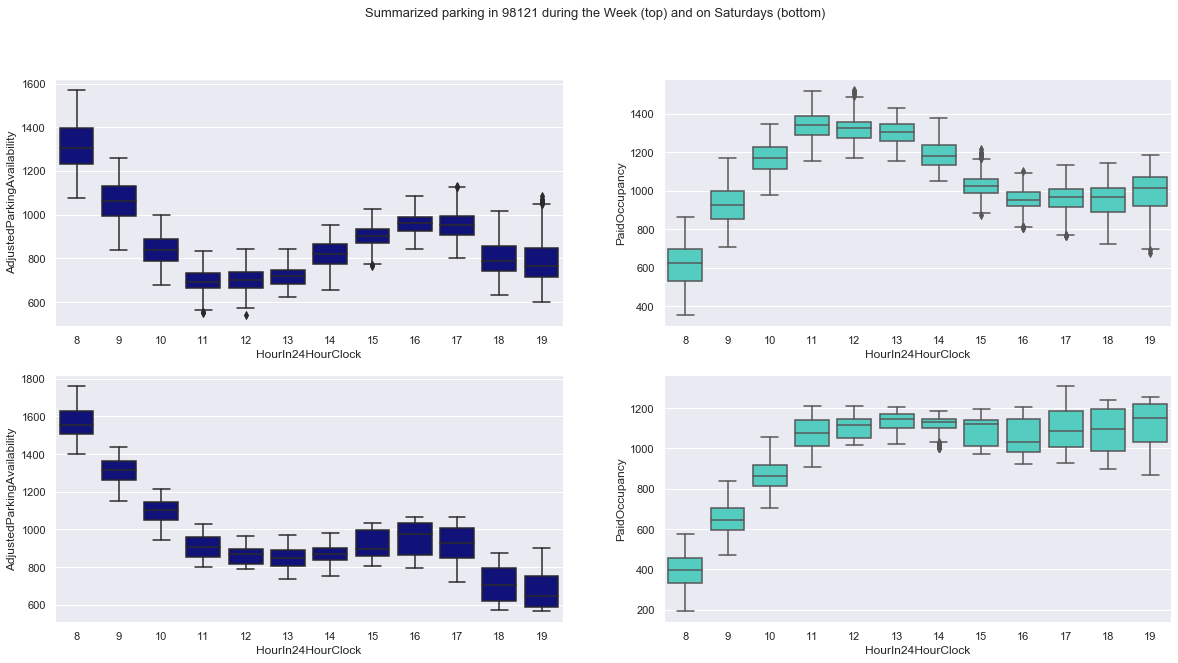

In [350]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
_ = sns.boxplot(x='HourIn24HourClock', y='AdjustedParkingAvailability', data=data_zip_98121_week, color='darkblue', ax=ax[0, 0])
_ = sns.boxplot(x='HourIn24HourClock', y='PaidOccupancy', data=data_zip_98121_week, color='turquoise', ax=ax[0, 1])
_ = sns.boxplot(x='HourIn24HourClock', y='AdjustedParkingAvailability', data=data_zip_98121_saturday, color='darkblue', ax=ax[1, 0])
_ = sns.boxplot(x='HourIn24HourClock', y='PaidOccupancy', data=data_zip_98121_saturday, color='turquoise', ax=ax[1, 1])
_ = plt.suptitle('Summarized parking in 98121 during the Week (top) and on Saturdays (bottom)', fontsize=13)
plt.show()

Now let's take a look at how paid parking availability and occupancy vary across the different zip codes. As expected from what we have already seen in some of the bar graphs above there are great differences in how much paid parking there is available in the different zip codes.

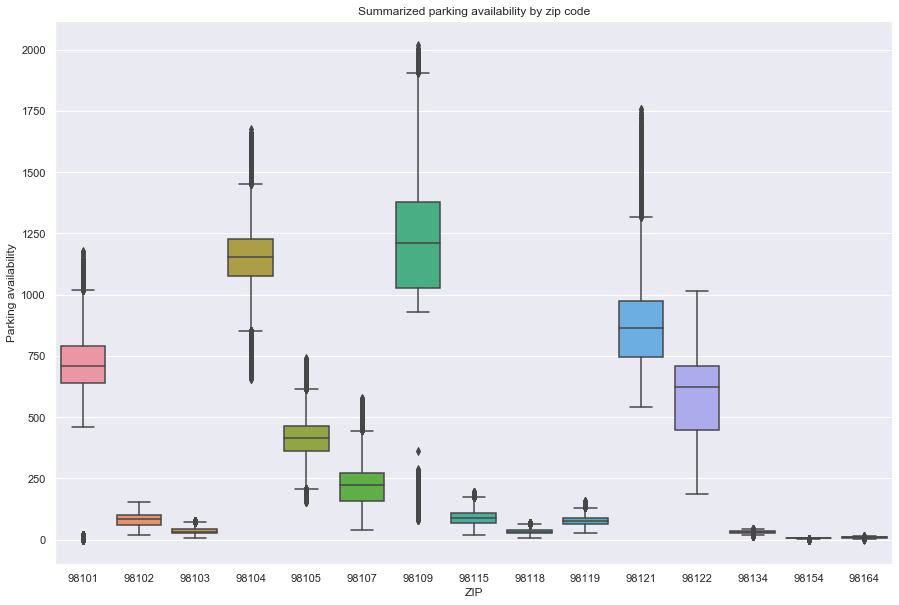

In [351]:
plt.figure(figsize=(15,10))
_ = sns.boxplot(x='ZIP', y='AdjustedParkingAvailability', data=data_groupby_zip)
_ = plt.xlabel('ZIP')
_ = plt.ylabel('Parking availability')
_ = plt.title('Summarized parking availability by zip code')
plt.show()

Since those differences are so big, it becomes difficult to properly read the plot. That is why we split it into two, one for the zip codes with less parking available and one with more. For the most part we see what we expected, the spreads looking similar for occupancy and availability. What stands out is that for the zip codes with the most available parking the spread for occupancy is much larger than the spread for availability. We can't explain that, but it would be worth looking into further.

In [73]:
# plot boxplot with data for smaller zip codes
data_small_zip = data_groupby_zip.loc[data_groupby_zip['ZIP'].isin([98102, 98103, 98115, 98118, 98119, 98134, 98154, 98164])]

In [74]:
# plot boxplot with data for smaller zip codes
data_big_zip = data_groupby_zip.loc[data_groupby_zip['ZIP'].isin([98101, 98104, 98105, 98107, 98109, 98121, 98122])]

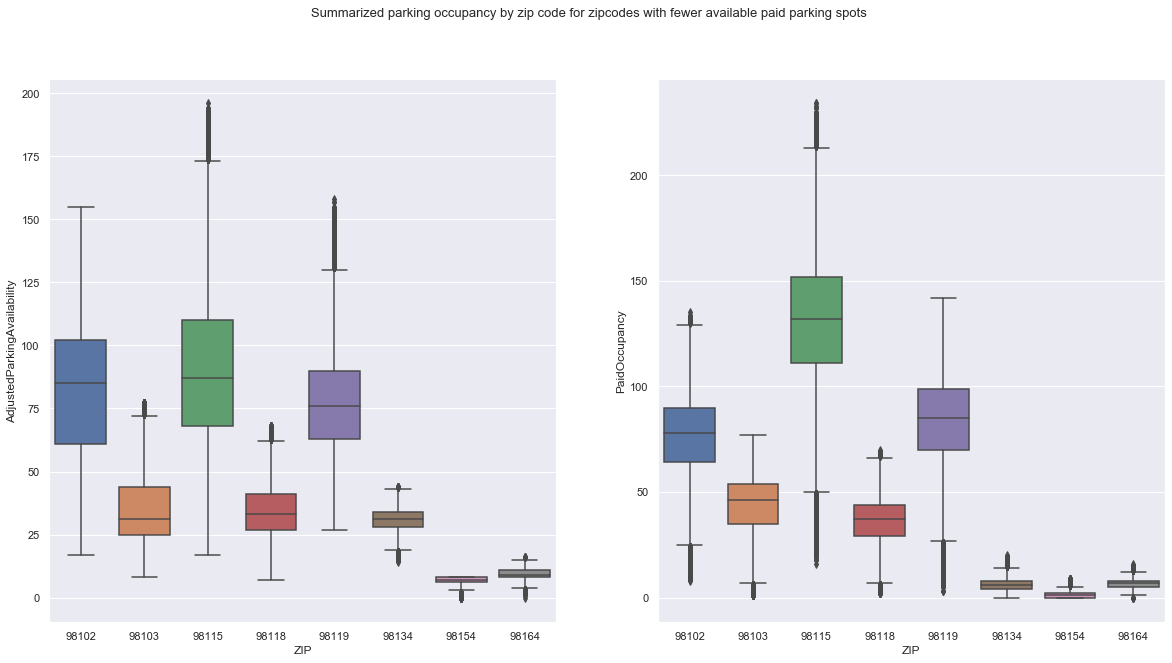

In [352]:
fig, ax = plt.subplots(ncols = 2, figsize=(20, 10))
_ = sns.boxplot(x='ZIP', y='AdjustedParkingAvailability', data=data_small_zip, ax=ax[0])
#_ = plt.subtitle('Summarizing parking availability by zip code', fontsize=13)
_ = sns.boxplot(x='ZIP', y='PaidOccupancy', data=data_small_zip, ax=ax[1])
p2 = plt.suptitle('Summarized parking occupancy by zip code for zipcodes with fewer available paid parking spots', fontsize=13)
plt.show()

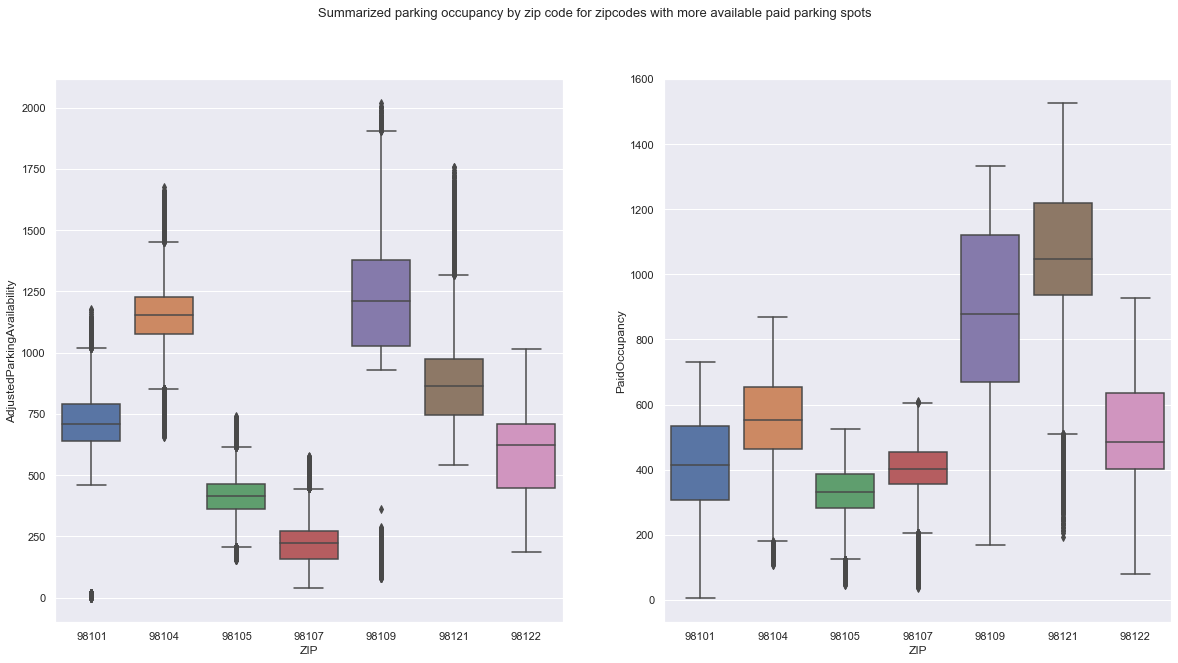

In [353]:
fig, ax = plt.subplots(ncols = 2, figsize=(20, 10))
p1 = sns.boxplot(x='ZIP', y='AdjustedParkingAvailability', data=data_big_zip, ax=ax[0])
p1 = plt.suptitle('Summarizing parking availability by zip code', fontsize=13)
p2 = sns.boxplot(x='ZIP', y='PaidOccupancy', data=data_big_zip, ax=ax[1])
p2 = plt.suptitle('Summarized parking occupancy by zip code for zipcodes with more available paid parking spots', fontsize=13)
plt.show()

## Anomalies

We didn't notice any major exceptions looking at the zip code based areas, but if we look at areas designated by the city - as structured in the original data - we notice that there are some areas that stand out. The particularly low parking availability for Belltown is expected as its area closely matches that of zip code 98121, which is one of the busier ones. Another anomaly is Ballard Locks witch shows overall high availability with outliers at the bottom end.

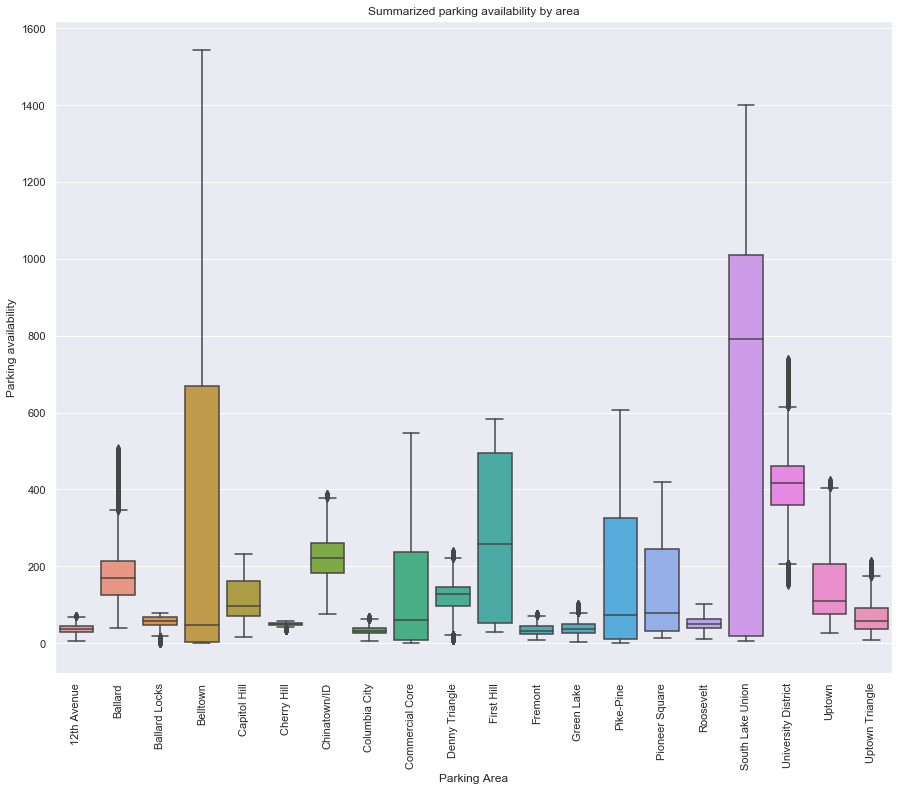

In [348]:
# create a box plot of parking availability, group by parking area
plt.figure(figsize=(15,12))
_ = sns.boxplot(x='PaidParkingArea', y='AdjustedParkingAvailability', data=data_groupby_parking_area)
_ = plt.xlabel('Parking Area')
_ = plt.ylabel('Parking availability')
_ = plt.xticks(rotation=90)
_ = plt.title('Summarized parking availability by area')
plt.show()

Looking a bit closer at Ballard Locks we notice an unusual pattern. Occupancy is low during the week, compared to other locations. But occupancy on Saturdays is higher than expected. After looking it up the location on Google maps we uncovered that it's a historical place with various attractions.

Another thing we can observe here is that the top of this stacked bar graph is nearly, something we expected in the 'Ratio of average parking availability and occupancy for each hour per zip code' above, but noticed that different areas have their own timetables for paid parking. For Ballard Locks parking is paid every day from 8:00 to 18:00, for the whole area.

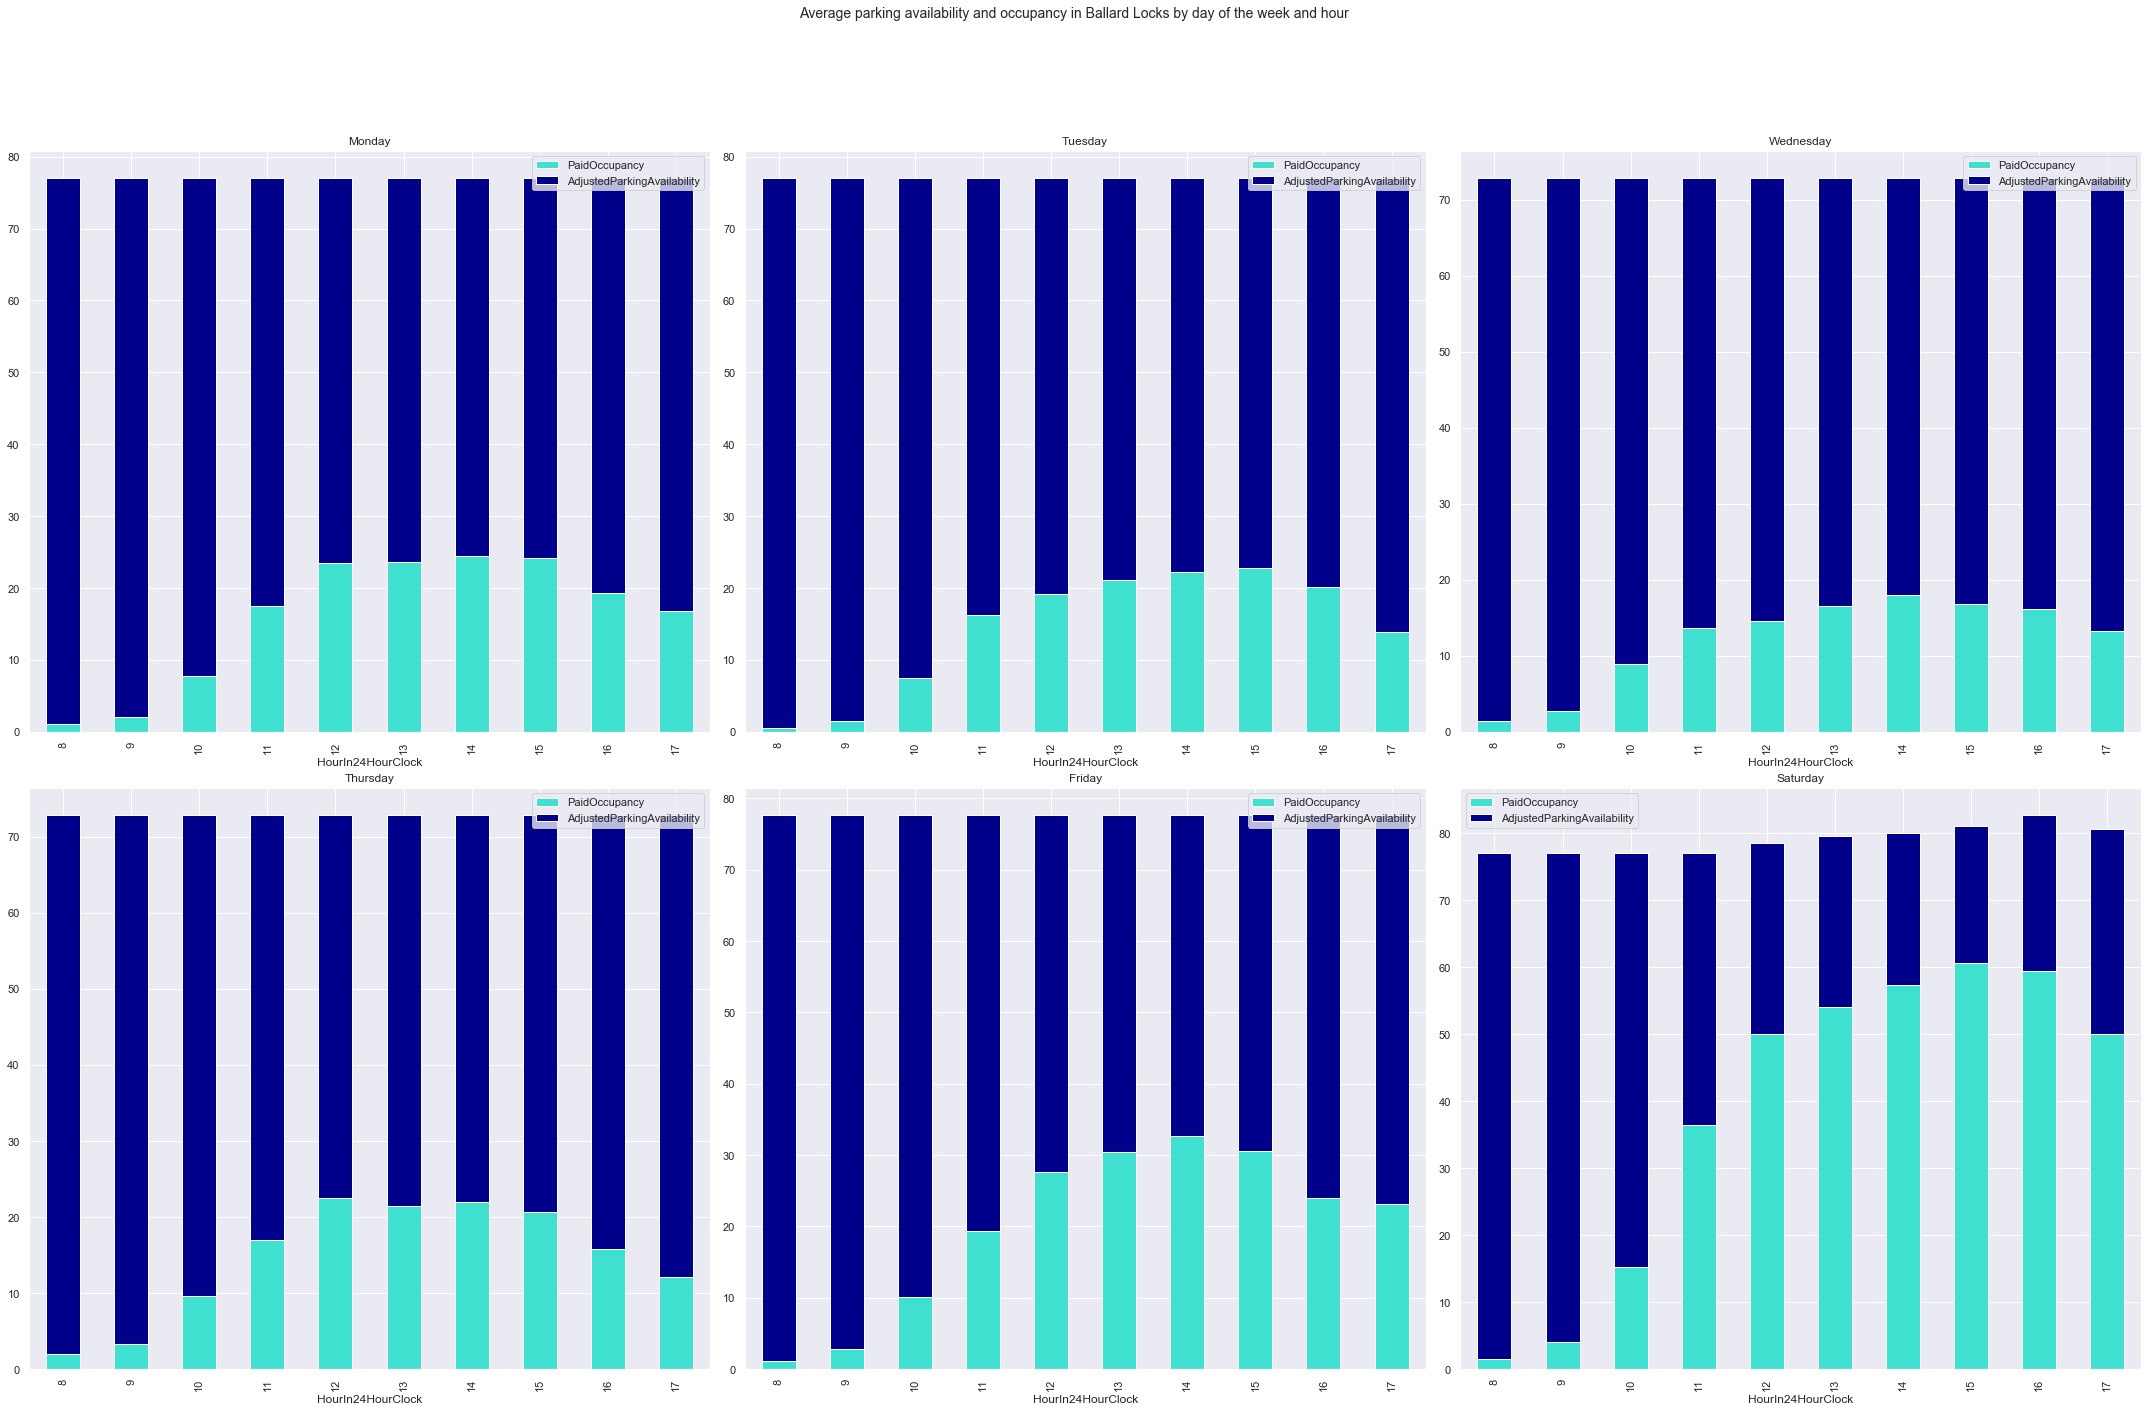

In [21]:
# plot subplots by day of the week and hour for average parking - both available and occupied - in Ballard Locks
colors= ['turquoise', 'darkblue']
fig, axes = plt.subplots(2, 3, figsize=(30, 20))

mon_day = data_BallardLocks[data_BallardLocks['Weekday']=='Monday'].groupby('HourIn24HourClock')['PaidOccupancy', 'AdjustedParkingAvailability'].mean().plot(kind='bar', stacked=True, color=colors, ax=axes[0, 0])
mon_day.set_title('Monday')
tue_day = data_BallardLocks[data_BallardLocks['Weekday']=='Tuesday'].groupby('HourIn24HourClock')['PaidOccupancy', 'AdjustedParkingAvailability'].mean().plot(kind='bar', stacked=True, color=colors, ax=axes[0, 1])
tue_day.set_title('Tuesday')
wed_day = data_BallardLocks[data_BallardLocks['Weekday']=='Wednesday'].groupby('HourIn24HourClock')['PaidOccupancy', 'AdjustedParkingAvailability'].mean().plot(kind='bar', stacked=True, color=colors, ax=axes[0, 2])
wed_day.set_title('Wednesday')
thu_day = data_BallardLocks[data_BallardLocks['Weekday']=='Thursday'].groupby('HourIn24HourClock')['PaidOccupancy', 'AdjustedParkingAvailability'].mean().plot(kind='bar', stacked=True, color=colors, ax=axes[1, 0])
thu_day.set_title('Thursday')
fri_day = data_BallardLocks[data_BallardLocks['Weekday']=='Friday'].groupby('HourIn24HourClock')['PaidOccupancy', 'AdjustedParkingAvailability'].mean().plot(kind='bar', stacked=True, color=colors, ax=axes[1, 1])
fri_day.set_title('Friday')
sat_day = data_BallardLocks[data_BallardLocks['Weekday']=='Saturday'].groupby('HourIn24HourClock')['PaidOccupancy', 'AdjustedParkingAvailability'].mean().plot(kind='bar', stacked=True, color=colors, ax=axes[1, 2])
sat_day.set_title('Saturday')

fig.suptitle('Average parking availability and occupancy in Ballard Locks by day of the week and hour', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

## Supply and Demand

We also wanted to understand how well the city is serving the needs of people in terms of paid parking availability in Seattle. We looked at one occasion for each zip code where parking occupancy was at its peak and looked at the availability for that moment in time. Especially areas with generally more availability still had space available event at its peak. The exception being 98107, which also includes Ballard Locks. Zip codes with less general availability were close to or at capacity at the time of their peak.

With some further exploration we would take a look at the number of occurrences when certain zip codes were close to or at capacity, to better understand if those events are frequent or just outliers in the graph below.

In [298]:
data_looking_max = data_groupby_zip[['ZIP','PaidOccupancy', 'AdjustedParkingAvailability']]

In [307]:
df_max_occupancy = data_looking_max.loc[data_looking_max.groupby('ZIP')['PaidOccupancy'].idxmax()]

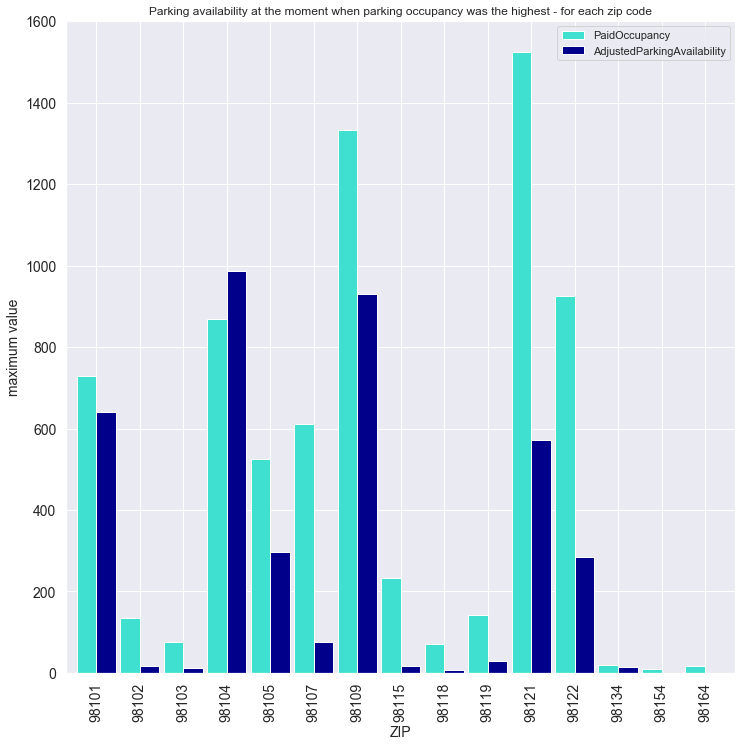

In [347]:
df_max_occupancy.plot.bar(x='ZIP', y=['PaidOccupancy', 'AdjustedParkingAvailability'],  figsize=(12, 12), width=0.9,  color=two_colors, fontsize=14)
plt.xlabel('ZIP', fontsize=14)
plt.ylabel('maximum value', fontsize=14)
plt.title('Parking availability at the moment when parking occupancy was the highest - for each zip code')
plt.show()

# Conclusion and Further Exploration

We are able to establish that paid parking occupancy is fairly predictable for the city of Seattle and the explored time frame from 21.03.2018 to 20.04.2019. The data follows weekly as well as daily and hourly patterns. There were very few outliers or anomalies. What that tells us is that people follow predictable day-to-day patterns when it comes to parking. And apart from a few areas with a smaller number of paid parking spaces available, the people of Seattle seem to have ample paid parking options. At least based on the data at hand.

For further exploration we would like to take a look at longer timeframe to identify patterns and trends across months and years. Furthermore we would have liked to explore the effects free parking has on paid parking, if that data were available. One additional aspect to test could be the effects of the price of parking on availability. 